In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [2]:
# 데이터셋 인스턴스 생성

data = pd.read_csv(r"C:\Users\tjdgu\CodingFiles\AI_Introduction\week6\diabetes.csv")  # CSV 파일 경로

In [3]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: ylabel='count'>

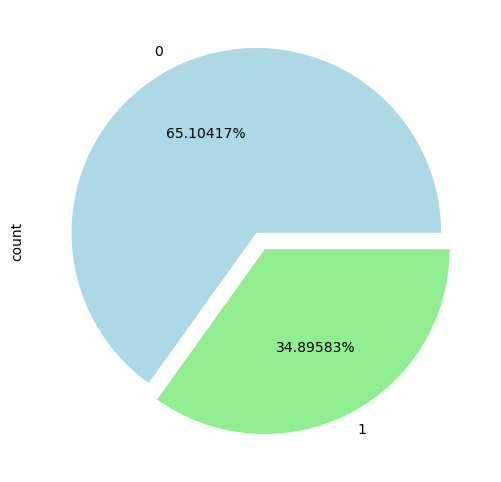

In [4]:
# 'Outcome' 0/1 비율 시각화
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.Outcome.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05))

In [5]:
# 데이터에서 입력값(X)과 정답값(y) 분리
X = data.drop('Outcome', axis=1).values  # 특성 8개
y = data['Outcome'].values.astype(np.float32)  # 회귀용 → 실수(float32)로 변환

In [6]:
# 데이터 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 훈련 데이터, 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [8]:
# 넘파이 → PyTorch 텐서로 변환
# 회귀 모델은 출력값이 (배치, 1) 모양이어야 하므로 .view(-1, 1) 필수
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [9]:
# 데이터를 배치사이즈 만큼 꺼내줌
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 입력값, 정답값 하나로 묶기
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

# 모델 정의

In [11]:
# 회귀 모델 정의: 출력 노드를 1개로 설정
class DiabetesRegressor(nn.Module):
    def __init__(self):
        super(DiabetesRegressor, self).__init__()
        self.fc1 = nn.Linear(8, 64)   # 입력: 8개 특성
        self.fc2 = nn.Linear(64, 32)  # 은닉층: 64 → 32
        self.fc3 = nn.Linear(32, 1)   # 출력층: 예측값 1개 (회귀)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # 마지막에는 활성화 함수 없이 그대로 출력

# 모델 인스턴스 생성
model = DiabetesRegressor()

# 손실 함수 및 최적화 기법 정의

In [12]:
# 회귀용 손실 함수: 평균제곱오차 (Mean Squared Error)
criterion = nn.MSELoss()

# Adam 최적화 기법 사용
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습

In [13]:
# 에폭별 손실값과 테스트 MSE를 저장할 리스트 초기화
train_losses = []
test_mses = []

# 학습을 20번 반복 (에폭 수)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # 학습 모드 설정 (Dropout, BatchNorm 등이 활성화됨)
    running_loss = 0.0  # 에폭 동안 누적 손실값

    # 훈련 데이터셋을 미니배치 단위로 순회
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()        # 이전 step의 기울기 초기화
        outputs = model(inputs)      # 순전파 → 예측값 계산
        loss = criterion(outputs, labels)  # 손실 함수로 오차 계산 (MSE)
        loss.backward()              # 역전파 → 기울기 계산
        optimizer.step()             # 옵티마이저로 가중치 업데이트

        running_loss += loss.item()  # 배치 손실 누적

    # 에폭당 평균 손실 저장
    train_losses.append(running_loss / len(train_dataloader))

    # === 테스트 성능 평가 (MSE 기반) ===
    model.eval()  # 평가 모드 전환 (Dropout 등 비활성화)
    predictions, actuals = [], []  # 예측값/실제값 저장 리스트

    with torch.no_grad():  # 평가 시에는 기울기 계산 비활성화 (메모리 효율↑)
        for inputs, labels in test_dataloader:
            outputs = model(inputs)  # 예측값 계산
            # .squeeze(): 텐서 차원을 줄여서 1D 배열로 만듦
            predictions.extend(outputs.squeeze().cpu().numpy())  
            actuals.extend(labels.squeeze().cpu().numpy())

    # 평균 제곱 오차(MSE) 계산
    mse = mean_squared_error(actuals, predictions)
    test_mses.append(mse)

    # 에폭별 훈련 손실과 테스트 MSE 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Test MSE: {mse:.4f}")

Epoch 1/20, Loss: 0.2170, Test MSE: 0.1709
Epoch 2/20, Loss: 0.1761, Test MSE: 0.1481
Epoch 3/20, Loss: 0.1705, Test MSE: 0.1408
Epoch 4/20, Loss: 0.1613, Test MSE: 0.1392
Epoch 5/20, Loss: 0.1589, Test MSE: 0.1373
Epoch 6/20, Loss: 0.1524, Test MSE: 0.1388
Epoch 7/20, Loss: 0.1475, Test MSE: 0.1382
Epoch 8/20, Loss: 0.1456, Test MSE: 0.1391
Epoch 9/20, Loss: 0.1444, Test MSE: 0.1386
Epoch 10/20, Loss: 0.1494, Test MSE: 0.1418
Epoch 11/20, Loss: 0.1409, Test MSE: 0.1395
Epoch 12/20, Loss: 0.1395, Test MSE: 0.1429
Epoch 13/20, Loss: 0.1441, Test MSE: 0.1426
Epoch 14/20, Loss: 0.1390, Test MSE: 0.1436
Epoch 15/20, Loss: 0.1376, Test MSE: 0.1446
Epoch 16/20, Loss: 0.1345, Test MSE: 0.1447
Epoch 17/20, Loss: 0.1356, Test MSE: 0.1461
Epoch 18/20, Loss: 0.1340, Test MSE: 0.1442
Epoch 19/20, Loss: 0.1376, Test MSE: 0.1460
Epoch 20/20, Loss: 0.1282, Test MSE: 0.1461


# 모델 평가

In [14]:
# 평가 모드로 전환
model.eval()

# 예측값과 실제값 저장 리스트
predictions, actuals = [], []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())  # 예측값
        actuals.extend(labels.squeeze().cpu().numpy())       # 실제값

# 평균제곱오차 (MSE) 계산
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actuals, predictions)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.1461


c:\Users\tjdgu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tjdgu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44480 (\N{HANGUL SYLLABLE GWI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tjdgu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tjdgu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tjdgu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes

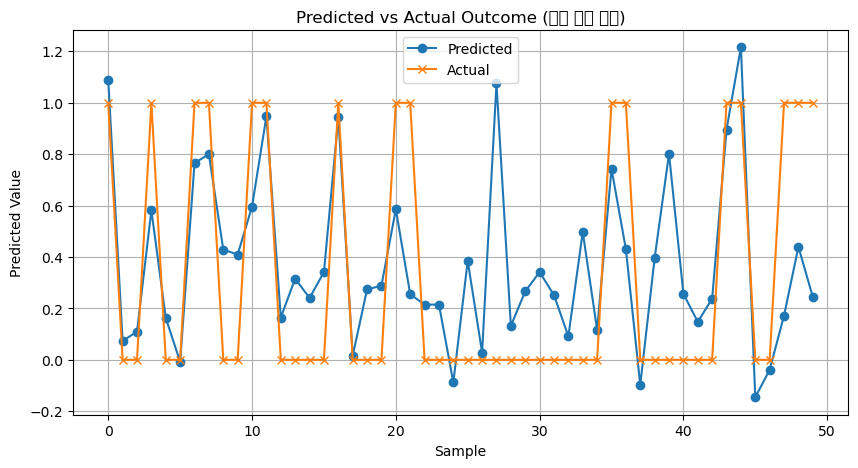

In [15]:
# 예측값과 실제값을 나란히 시각화하여 비교
plt.figure(figsize=(10, 5))
plt.plot(predictions[:50], label='Predicted', marker='o')
plt.plot(actuals[:50], label='Actual', marker='x')
plt.title('Predicted vs Actual Outcome (회귀 결과 비교)')
plt.xlabel('Sample')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()